In [1]:
import math
import numpy as np
import pandas as pd
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score
import matplotlib.pyplot as plt

from src.model import MockModel
from src.utils import strip_label, index_for_arange
import src.plot as plot
from src.eval import (
    adjusted_classification_x_width_score,
    classification_x_width_score,
    cq_stats,
    cq_width_score,
    size_stratified_classification_coverage_score,
    set_size_equals,
)
from src.heuristics import TopKSelector, HeuristicCutoffSelector, TopKCutoffSelector

In [2]:
import pandas as pd

In [3]:
data_dir = "data/banking77/dfcx/"

# NOTE: we do not need predictions on the train set, but they can be included for completeness
#df_train_preds = pd.read_csv("dfcx_banking77/calibration_sample.csv").reset_index() # change to file with confidence scores on train set
df_test_preds = pd.read_csv(data_dir + "test_predictions.csv").reset_index()
df_calibration_preds = pd.read_csv(data_dir + "calibration_predictions.csv").reset_index()

N_INTENTS = 77

In [4]:
label_names = list(lambda x: 'label_{}'.format(x) for x in range(N_INTENTS))

In [5]:
df_test = df_test_preds.reset_index().rename(columns={'level_0': 'utterance'})
df_calibration = df_calibration_preds.reset_index().rename(columns={'level_0': 'utterance'})

df_test['utterance'] = df_test['utterance'].apply(lambda h: 'test_' + str(h))
df_calibration['utterance'] = df_calibration['utterance'].apply(lambda h: 'cal_' + str(h))

In [6]:
df_test['utterance'] = df_test['utterance'].astype(str)
df_calibration['utterance'] = df_calibration['utterance'].astype(str)

In [7]:
# fullset = pd.concat([df_train, df_test, df_calibration], ignore_index=True).drop_duplicates(['utterance'])
fullset = pd.concat([df_test, df_calibration], ignore_index=True)
assert fullset.utterance.value_counts().max() == 1, "Hashes/utterances should be unique in full set"
fullset = fullset.drop(['label', 'index', 'Right_index', 'Unnamed: 0', 'intent', 'hash', 'label_fallback'], axis=1)
fullset.head()

,utterance,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,...,label_67,label_68,label_69,label_70,label_71,label_72,label_73,label_74,label_75,label_76
0,test_0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
1,test_1,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
2,test_2,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.8421,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
3,test_3,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.4843,0.0,0.0,0.0
4,test_4,0.0,0.0,0.0,0.5074,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5087,0.0,0.0,0.0


In [8]:
# X_train = df_train[['utterance']]
X_train = fullset[['utterance']]
X_calib = df_calibration[['utterance']]
X_test = df_test[['utterance']]

a_start = 0.01
a_stop = .4
a_step = 0.01
alpha = np.arange(a_start, a_stop, a_step)

max_ps_size = math.ceil(N_INTENTS * .25)
max_ps_size = 4

target_alpha = .1
target_index = index_for_arange(a_start, a_step ,target_alpha)

In [9]:
normalized_model = MockModel(fullset, 'utterance', softmax=True)
normalized_model.fit(X_test, df_test['label'])

raw_model = MockModel(fullset, 'utterance', softmax=False, raw=True)
raw_model.fit(X_test, df_test['label'])
y_test = df_test['label'].apply(lambda lbl: list(normalized_model.classes_).index(lbl))

/home/floris/projects/cicc/src/eval.py:78: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


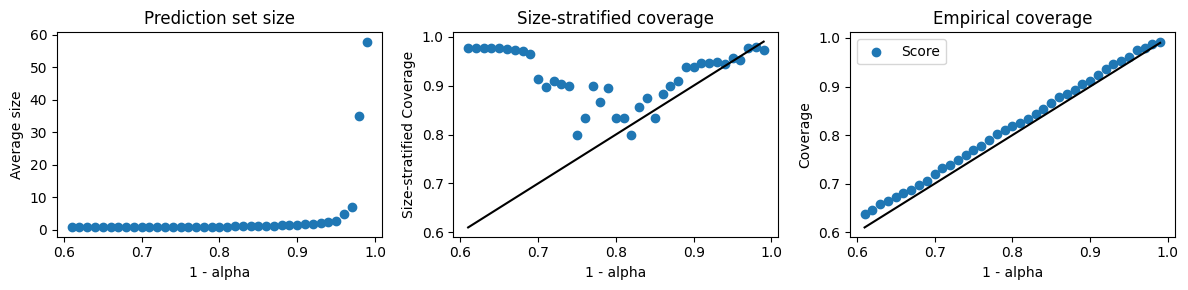

(0.9116883116883117,
 1.4503246753246752,
 0.9382716049382716,
 2020,
 1.2924496071062521)

In [10]:
mapie_score = MapieClassifier(estimator=normalized_model, cv="prefit", method="score", random_state=3)
mapie_score.fit(X_calib, df_calibration['label'])
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)

coverages_score = [
    classification_coverage_score(y_test, y_ps_score[:, :, i])
    for i, _ in enumerate(alpha)
]
widths_mean_score = [
    classification_mean_width_score(y_ps_score[:, :, i])
    for i, _ in enumerate(alpha)
]
adjusted_width_score = [
    adjusted_classification_x_width_score(y_ps_score[:, :, i], np.mean, max_ps_size)
    for i, _ in enumerate(alpha)
]
ssc_score = [
    size_stratified_classification_coverage_score(y_test, y_ps_score[:, :, i])
    for i, _ in enumerate(alpha)
]
plot.plot_coverages_widths(alpha, coverages_score, widths_mean_score, "Score", ssc_score, True, "banking77", "dfcx")

coverages_score[target_index], widths_mean_score[target_index], ssc_score[target_index], set_size_equals(y_ps_score[:,:,target_index], 1), adjusted_width_score[target_index]

In [11]:
2020 / y_ps_score.shape[0], set_size_equals(y_ps_score[:,:,target_index], 0)


(0.6558441558441559, 128)

In [12]:
y_ps_t = y_ps_score[:, :, target_index]
set_size_equals(y_ps_t, 1)/y_ps_t.shape[0], cq_width_score(y_ps_t, np.mean, max_ps_size)

(0.6558441558441559, 2.263157894736842)

/home/floris/projects/cicc/src/eval.py:78: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


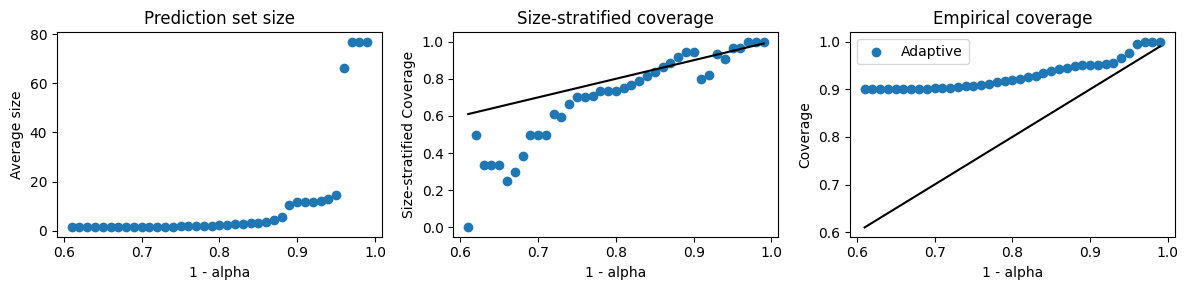

(0.9503246753246753,
 11.765584415584415,
 0.9428251121076233,
 0,
 2.0011198208286674)

In [13]:
mapie_cum = MapieClassifier(estimator=normalized_model, cv="prefit", method="cumulated_score", random_state=3)
mapie_cum.fit(X_calib, df_calibration['label'])
y_pred_cum, y_ps_cum = mapie_cum.predict(X_test, alpha=alpha)

coverages_cum = [
    classification_coverage_score(y_test, y_ps_cum[:, :, i])
    for i, _ in enumerate(alpha)
]
widths_mean_cum = [
    classification_mean_width_score(y_ps_cum[:, :, i])
    for i, _ in enumerate(alpha)
]
adjusted_width_cum = [
    adjusted_classification_x_width_score(y_ps_cum[:, :, i], np.mean, max_ps_size)
    for i, _ in enumerate(alpha)
]
ssc_cum = [
    size_stratified_classification_coverage_score(y_test, y_ps_cum[:, :, i])
    for i, _ in enumerate(alpha)
]
plot.plot_coverages_widths(alpha, coverages_cum, widths_mean_cum, "Adaptive", ssc_cum, True, "banking77", "dfcx")
coverages_cum[target_index], widths_mean_cum[target_index], ssc_cum[target_index], set_size_equals(y_ps_cum[:,:,target_index], 1), adjusted_width_cum[target_index]

/home/floris/projects/cicc/src/eval.py:78: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


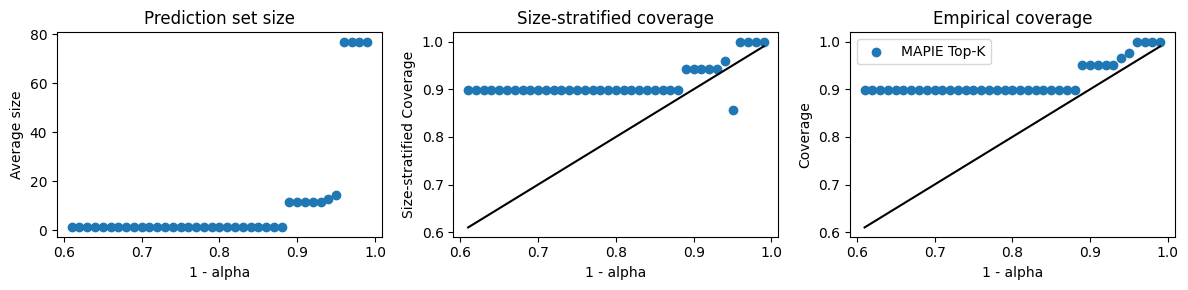

(0.9503246753246753,
 11.765584415584415,
 0.9428251121076233,
 0,
 2.0011198208286674)

In [14]:
mapie_topkmapie = MapieClassifier(estimator=normalized_model, cv="prefit", method="top_k", random_state=3)
mapie_topkmapie.fit(X_calib, df_calibration['label'])
y_pred_topkmapie, y_ps_topkmapie = mapie_topkmapie.predict(X_test, alpha=alpha)

coverages_topkmapie = [
    classification_coverage_score(y_test, y_ps_topkmapie[:, :, i])
    for i, _ in enumerate(alpha)
]
widths_mean_topkmapie = [
    classification_mean_width_score(y_ps_topkmapie[:, :, i])
    for i, _ in enumerate(alpha)
]
adjusted_width_topkmapie = [
    adjusted_classification_x_width_score(y_ps_topkmapie[:, :, i], np.mean, max_ps_size)
    for i, _ in enumerate(alpha)
]
ssc_topkmapie = [
    size_stratified_classification_coverage_score(y_test, y_ps_topkmapie[:, :, i])
    for i, _ in enumerate(alpha)
]
plot.plot_coverages_widths(alpha, coverages_topkmapie, widths_mean_topkmapie, "MAPIE Top-K", ssc_topkmapie, True, "banking77", "dfcx")
coverages_topkmapie[target_index], widths_mean_topkmapie[target_index], ssc_topkmapie[target_index], set_size_equals(y_ps_topkmapie[:, :, target_index], 1), adjusted_width_topkmapie[target_index]

/home/floris/projects/cicc/src/eval.py:78: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


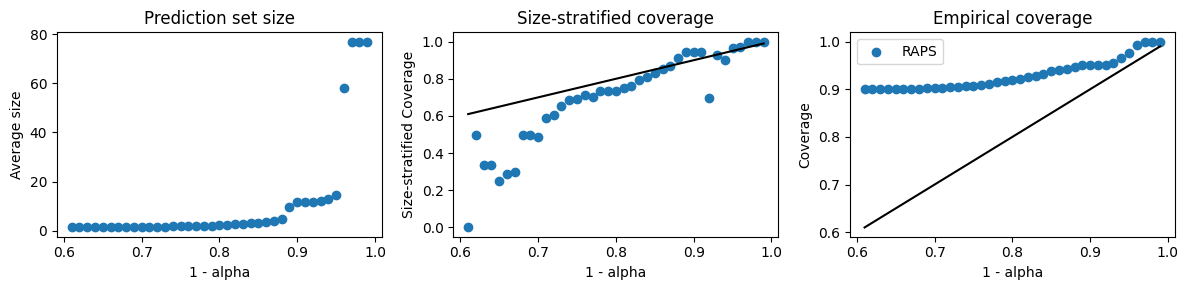

(0.9503246753246753,
 11.765584415584415,
 0.9428251121076233,
 0,
 2.0011198208286674)

In [15]:
mapie_raps = MapieClassifier(estimator=normalized_model, cv="prefit", method="raps")
mapie_raps.fit(X_calib, df_calibration['label'])
y_pred_raps, y_ps_raps = mapie_raps.predict(X_test, alpha=alpha)

coverages_raps = [
    classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
widths_mean_raps = [
    classification_mean_width_score(y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
adjusted_width_raps = [
    adjusted_classification_x_width_score(y_ps_raps[:, :, i], np.mean, max_ps_size)
    for i, _ in enumerate(alpha)
]
ssc_raps = [
    size_stratified_classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
plot.plot_coverages_widths(alpha, coverages_raps, widths_mean_raps, "RAPS", ssc_raps, True, "banking77", "dfcx")
coverages_raps[target_index], widths_mean_raps[target_index], ssc_raps[target_index], set_size_equals(y_ps_raps[:, :, target_index], 1), adjusted_width_raps[target_index]

In [16]:
topk_5 = TopKSelector(estimator=raw_model, k=5)
y_ps_topk_5 = topk_5.predict(X_test)

coverages_topk_5 = classification_coverage_score(y_test, y_ps_topk_5)
widths_mean_topk_5 = classification_mean_width_score(y_ps_topk_5)
adjusted_width_topk_5 = adjusted_classification_x_width_score(y_ps_topk_5, np.mean, max_ps_size)
ssc_topk_5 = size_stratified_classification_coverage_score(y_test, y_ps_topk_5)

coverages_topk_5, widths_mean_topk_5, ssc_topk_5, set_size_equals(y_ps_topk_5, 1), adjusted_width_topk_5

/home/floris/projects/cicc/src/eval.py:78: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9720779220779221, 5.0, 0.9720779220779221, 0, nan)

In [17]:
y_ps_t = y_ps_topk_5
set_size_equals(y_ps_t, 1)/y_ps_t.shape[0], cq_width_score(y_ps_t, np.mean, max_ps_size)

/home/floris/projects/cicc/src/eval.py:110: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.0, nan)

In [18]:
top_95 = HeuristicCutoffSelector(estimator=raw_model, cutoff=1-target_alpha)
y_ps_top_95 = top_95.predict(X_test)

coverages_top_95 = classification_coverage_score(y_test, y_ps_top_95)
widths_mean_top_95 = classification_mean_width_score(y_ps_top_95)
adjusted_width_top_95 = adjusted_classification_x_width_score(y_ps_top_95, np.mean, max_ps_size)
ssc_top_95 = size_stratified_classification_coverage_score(y_test, y_ps_top_95)

coverages_top_95, widths_mean_top_95, ssc_top_95, set_size_equals(y_ps_top_95, 1), adjusted_width_top_95

(0.8993506493506493,
 1.027922077922078,
 0.7142857142857143,
 3012,
 1.0227642276422764)

In [19]:
y_ps_t = y_ps_top_95
set_size_equals(y_ps_t, 1)/y_ps_t.shape[0], cq_width_score(y_ps_t, np.mean, max_ps_size)

(0.977922077922078, 2.111111111111111)

In [20]:
3012 / y_ps_top_95.shape[0], set_size_equals(y_ps_top_95, 0)

(0.977922077922078, 0)

In [21]:
top_5_95 = TopKCutoffSelector(estimator=raw_model, cutoff=1-target_alpha, k=5)
y_ps_top_5_95 = top_5_95.predict(X_test)

coverages_top_5_95 = classification_coverage_score(y_test, y_ps_top_5_95)
widths_mean_top_5_95 = classification_mean_width_score(y_ps_top_5_95)
adjusted_width_top_5_95 = adjusted_classification_x_width_score(y_ps_top_5_95, np.mean, max_ps_size)
ssc_top_5_95 = size_stratified_classification_coverage_score(y_test, y_ps_top_5_95)

coverages_top_5_95, widths_mean_top_5_95, ssc_top_5_95, set_size_equals(y_ps_top_5_95, 1), adjusted_width_top_5_95

(0.9522727272727273,
 2.098051948051948,
 0.7142857142857143,
 2188,
 1.0310972900932918)

In [22]:
y_ps_t = y_ps_top_5_95
set_size_equals(y_ps_t, 1)/y_ps_t.shape[0], cq_width_score(y_ps_t, np.mean, max_ps_size)

(0.7103896103896103, 2.111111111111111)

In [23]:
y_ps_t = y_ps_top_5_95
set_size_equals(y_ps_t, 1)/y_ps_t.shape[0], cq_width_score(y_ps_t)
cq_stats(y_ps_t, y_test, 4)

(0.9522727272727273,
 0.7103896103896103,
 0.021753246753246754,
 0.26785714285714285,
 2.111111111111111)

In [24]:
y_ps_t = y_ps_topk_5
set_size_equals(y_ps_t, 1)/y_ps_t.shape[0], cq_width_score(y_ps_t)
cq_stats(y_ps_t, y_test, 4)

/home/floris/projects/cicc/src/eval.py:110: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9720779220779221, 0.0, 0.0, 1.0, nan)

In [25]:
y_ps_t = y_ps_top_5_95
set_size_equals(y_ps_t, 1)/y_ps_t.shape[0], cq_width_score(y_ps_t)
cq_stats(y_ps_t, y_test, 4)

(0.9522727272727273,
 0.7103896103896103,
 0.021753246753246754,
 0.26785714285714285,
 2.111111111111111)

In [26]:
y_ps_t = y_ps_cum[:, :, target_index]
set_size_equals(y_ps_t, 1)/y_ps_t.shape[0], cq_width_score(y_ps_t)
cq_stats(y_ps_t, y_test, 4)

(0.9503246753246753,
 0.0,
 0.8698051948051948,
 0.1301948051948052,
 2.0011198208286674)

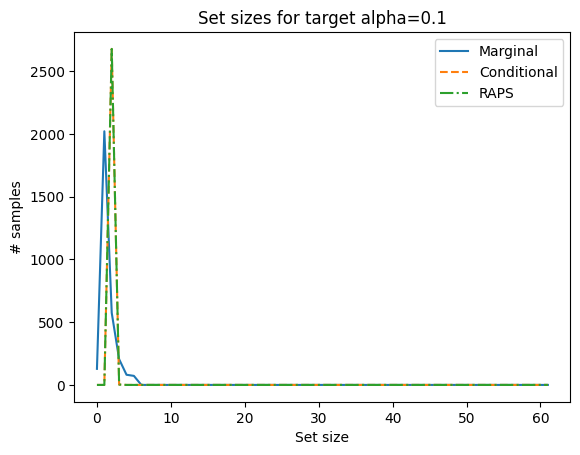

In [27]:
to_plot = [
    (y_ps_score, 'Marginal', '-', None),
    (y_ps_cum, 'Conditional', '--', None),
    (y_ps_raps, 'RAPS', '-.', None),
    # (y_ps_topkmapie, 'TOPK', ':', None),
    # (y_ps_top_5_95, 'heuristic a', 'dashed', 'black'),
    # (y_ps_top_95,  'heuristic b', 'dotted', 'black'),
    # (y_ps_topk_5,  'heuristic c', '-.', 'black'),
]
for (resultset, label, style, color) in to_plot:
    if len(label) > len('heuristic') and label[:len('heuristic')] == 'heuristic':
        to_plot_result = resultset
    else:
        to_plot_result = resultset[:, :, target_index]
    plt.plot([set_size_equals(to_plot_result, i) for i in range(62)], label=label, linestyle=style)
plt.xlabel('Set size')
plt.ylabel('# samples')
plt.title('Set sizes for target alpha={}'.format(target_alpha))
plt.legend()

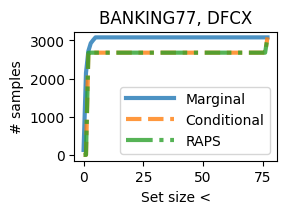

In [28]:
fig, ax = plt.subplots(1, 1, figsize=plot.fig_dim_1)

for (resultset, label, style, color) in to_plot:
    if len(label) > len('heuristic') and label[:len('heuristic')] == 'heuristic':
        to_plot_result = resultset
    else:
        to_plot_result = resultset[:, :, target_index]
    ax.plot(
        np.cumsum([set_size_equals(to_plot_result, i) for i in range(78)]),
        label=label,
        linestyle=style,
        color=color,
        linewidth=3,
        alpha=.8)
    # ax.set_xscale('log')
plt.legend(handlelength=2.5)
plt.xlabel('Set size <')
plt.ylabel('# samples')
plt.title('BANKING77, DFCX'.format(target_alpha))
plt.legend(handlelength=3.5)
plt.tight_layout()
plt.savefig('results/cum_set_size_BANKING77_DFCX.pdf', dpi=1200)

In [29]:
pd.Series(np.cumsum([set_size_equals(y_ps_cum[:, :, target_index], i) for i in range(78)])).to_csv('results/cum_b77_dfcx.csv')

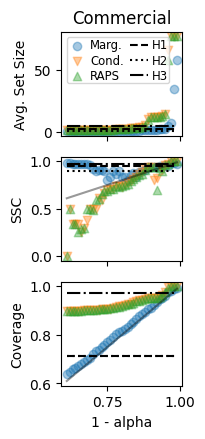

In [30]:
plot.plot_coverages_widths_multi(
    alpha,
    (coverages_score,
     coverages_cum,
     coverages_raps,
     # coverages_topkmapie,
    ),
    # (adjusted_width_score,
    #  adjusted_width_cum,
    #  adjusted_width_raps,
     # adjusted_width_topkmapie,
    # ),
    # (cq_width_score,
    #  cq_width_cum,
    #  cq_width_raps,
     # cq_width,topkmapie,
    # ),
    (widths_mean_score,
     widths_mean_cum,
     widths_mean_raps,
     # widths_mean_topkmapie
    ),
    ('Marg.', 'Cond.', 'RAPS',),#'TOPK'),
    legend=(0, 'upper left'),
    sscs=(ssc_score,
     ssc_cum,
     ssc_raps,
     # ssc_topkmapie,
    ),
    hlines=(
        (widths_mean_top_5_95, ssc_top_5_95, coverages_top_5_95,  'H1', 'dashed'),
        (widths_mean_top_95, ssc_top_95, coverages_top_95,  'H2', 'dotted'),
        (widths_mean_topk_5, ssc_topk_5, coverages_topk_5,  'H3', '-.'),
    ),
    markers=('o', 'v', '^',),
    plot_ssc=True,
    dataset='BANKING77',
    model='DFCX',
    title='Commercial')

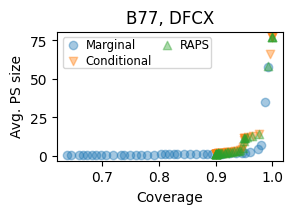

In [31]:
plot.plot_cov_x_width_multi(
    alpha,
    (coverages_score,
     coverages_cum,
     coverages_raps,
     # coverages_topkmapie,
    ),
    (widths_mean_score,
     widths_mean_cum,
     widths_mean_raps,
     widths_mean_topkmapie,
    ),
    # (adjusted_width_score,
    #  adjusted_width_cum,
    #  adjusted_width_raps,
    # adjusted_width_topkmapie,
    # ),
    # (cq_width_score,
    #  cq_width_cum,
    #  cq_width_raps,
    #  # cq_width,topkmapie,
    # ),
    ('Marginal', 'Conditional', 'RAPS',),#,'TOPK'),
    legend=(0, 'upper left'),
    sscs=(ssc_score,
     ssc_cum,
     ssc_raps,
    # ssc_topkmapie
    ),
    plot_ssc=False,
    # hlines=(
    #     (cq_width_top_5_95, ssc_top_5_95, coverages_top_5_95,  'H1', 'dashed'),
    #     (cq_width_top_95, ssc_top_95, coverages_top_95,  'H2', 'dotted'),
    #     (cq_width_topk_5, ssc_topk_5, coverages_topk_5,  'H3', '-.'),
    # ),
    markers=('o', 'v', '^',),
    dataset='B77',
    model='DFCX',)

In [32]:
max_ps_size

4

In [33]:
y_test

0       41
1       13
2        7
3       24
4       62
        ..
3075     6
3076    28
3077     0
3078    54
3079    65
Name: label, Length: 3080, dtype: int64

In [34]:
df_calibration.head()

,utterance,index,Unnamed: 0,hash,label,intent,Right_index,label_0,label_1,label_2,...,label_68,label_69,label_70,label_71,label_72,label_73,label_74,label_75,label_76,label_fallback
0,cal_0,0,457,00457-8930639a-aa5e-48fb-b835-02f7985f244d,5,5,457,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,NaN
1,cal_1,1,77,00077-fb1e96ac-cb38-414f-9364-cdbfa0d859f7,10,10,77,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,NaN
2,cal_2,2,2194,02194-ceb70a2c-781f-4372-9e4d-ac3be7b0bd7c,3,3,2194,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5796,0.0,0.5619,0.0000,NaN
3,cal_3,3,1328,01328-1b351985-0894-46b5-a6bc-d3dd6389ebee,46,46,1328,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.5266,0.0000,NaN
4,cal_4,4,2280,02280-f4283543-859a-4ba1-bd4c-34fc69dcfa16,76,76,2280,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.9701,NaN


In [35]:
list(df_test[(y_ps_score[:, :, target_index].sum(axis=1) == 5)].index)

[91,
 142,
 185,
 238,
 286,
 293,
 294,
 323,
 360,
 451,
 487,
 521,
 580,
 664,
 731,
 777,
 828,
 894,
 900,
 903,
 930,
 943,
 953,
 1018,
 1043,
 1111,
 1222,
 1267,
 1275,
 1390,
 1436,
 1446,
 1448,
 1455,
 1474,
 1503,
 1513,
 1529,
 1624,
 1652,
 1672,
 1731,
 1761,
 1812,
 1852,
 2019,
 2102,
 2150,
 2207,
 2262,
 2265,
 2391,
 2423,
 2481,
 2545,
 2643,
 2651,
 2686,
 2738,
 2754,
 2761,
 2769,
 2874,
 2881,
 2906,
 2922,
 3005,
 3007,
 3018,
 3020,
 3038,
 3040]